In [566]:
%pylab inline

from sklearn.datasets import fetch_openml

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import LeakyReLU, Dropout, ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop

from tqdm._tqdm_notebook import tqdm_notebook

#from PIL import Image

import tensorflow as tf
import xml.etree.ElementTree as ET 
import os
import cv2

Populating the interactive namespace from numpy and matplotlib


In [148]:
def jpg_image_to_array(image_path):
    with Image.open(image_path) as image:
        im_arr = np.frombuffer(image.tobytes(), dtype=np.uint8)
        im_arr = im_arr.reshape(image.size[1], image.size[0], 3)                                   
    return im_arr

def read_image(src):
    img = cv2.imread(src)
    if img is None:
        raise FileNotFoundError
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [440]:
annotation_dir = 'stanford-dogs-dataset/annotations/Annotation'
dog_breed_dict = {}
for annotation in os.listdir(annotation_dir):
    if annotation == '.DS_Store':
        continue
    annotations = annotation.split('-')
    dog_breed_dict[annotations[0]] = '-'.join(annotations[1:])

In [98]:
processed_dir = 'stanford-dogs-dataset/processed'

In [441]:
breed_directories = ['stanford-dogs-dataset/images/Images/{}-{}'.format(k,v) for k,v in dog_breed_dict.items()]

In [442]:
images = []
for breed in breed_directories:
    images += [breed+'/'+fname for fname in os.listdir(breed)]

In [444]:
maltese_code = [code for code in dog_breed_dict.keys() if dog_breed_dict[code] == 'Maltese_dog'][0]
maltese_dir = 'stanford-dogs-dataset/images/Images/{}-Maltese_dog'.format(maltese_code)

In [456]:
image_width = 64
image_height = 64
image_channels = 3
image_sample_size = 10000

def crop_image(path):
    image = read_image(path)
    tree = ET.parse(os.path.join(annotation_dir, '/'.join(path.split('/')[-2:])[:-4]))
    
    root = tree.getroot() 
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    objects = root.findall('object')
    
    bndbox = objects[0].find('bndbox') 

    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    # 4 : margin
    xmin = max(0, xmin - 4) 
    xmax = min(width, xmax + 4)
    ymin = max(0, ymin - 4)
    ymax = min(height, ymax + 4)

    # available w
    w = np.min((xmax - xmin, ymax - ymin))
    w = min(w, width, height)                     

    if w > xmax - xmin:
        xmin = min(max(0, xmin - int((w - (xmax - xmin))/2)), width - w)
        xmax = xmin + w
    if w > ymax - ymin:
        ymin = min(max(0, ymin - int((w - (ymax - ymin))/2)), height - w)
        ymax = ymin + w

    # [h,w,c]
    img_cropped = image[ymin:ymin+w, xmin:xmin+w, :]    

    # Interpolation method
    if xmax - xmin > image_width:
        # shrink
        interpolation = cv2.INTER_AREA          
    else:
        # expansion
        interpolation = cv2.INTER_CUBIC         

    # resize
    return cv2.resize(img_cropped, (image_width, image_height), interpolation=interpolation)

In [457]:
cropped = np.zeros(shape=(len(images),64,64,3))
for img_idx in tqdm_notebook(range(len(images))):
    cropped[img_idx] = crop_image(images[img_idx])

In [459]:
normed_images = (cropped - 127.5)/127.5

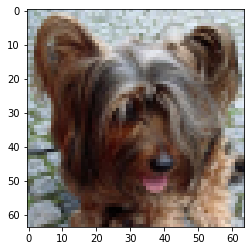

In [460]:
imshow(cropped[2]/252)

In [569]:
def transposed_conv(model, out_channels, ksize, stride_size, ptype='same'):
    model.add(Conv2DTranspose(out_channels, (ksize, ksize), strides=(stride_size, stride_size), padding=ptype, 
                              kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    return model

def conv(model, out_channels, ksize, stride_size):
    model.add(Conv2D(out_channels, (ksize, ksize), strides=(stride_size, stride_size), padding='same', 
                     kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(leaky_relu_slope))
    #model.add(Dropout(dropout_rate))
    return model

In [570]:
batch_size = 128
weight_init_std = 0.02
weight_init_mean = 0.0
leaky_relu_slope = 0.2
downsize_factor = 2
dropout_rate = 0.5
scale_factor = 4 ** downsize_factor
noise_dim = 128

In [571]:
def DogGenerator():
    model = Sequential()
    model.add(Dense(image_width // scale_factor * image_height // scale_factor * 128, input_shape=(noise_dim,)))
    #model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM))
    #model.add(LeakyReLU(alpha=leaky_relu_slope))
    model.add(Reshape((image_height // scale_factor, image_width // scale_factor, 128)))
    
    model = transposed_conv(model, 512, ksize=5, stride_size=1)
    model.add(Dropout(dropout_rate))
    model = transposed_conv(model, 256, ksize=5, stride_size=2)
    model.add(Dropout(dropout_rate))
    model = transposed_conv(model, 128, ksize=5, stride_size=2)
    model = transposed_conv(model, 64, ksize=5, stride_size=2)
    model = transposed_conv(model, 32, ksize=5, stride_size=2)
    
    model.add(Dense(3, activation='tanh'))
    return model

def DogDiscriminator():
    model = Sequential()
    model.add(Conv2D(64, (4, 4), strides=(2,2), padding='same', use_bias=False,
                         input_shape=(image_height, image_width, 3)))
    #model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM))
    model.add(LeakyReLU(alpha=leaky_relu_slope))
    #model.add(Dropout(dropout_rate))

    model = conv(model, 64, ksize=4, stride_size=2)
    model = conv(model, 128, ksize=4, stride_size=2)
    model = conv(model, 256, ksize=4, stride_size=2)

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [572]:
weight_initializer = tf.keras.initializers.TruncatedNormal(stddev=weight_init_std, mean=weight_init_mean, seed=42)

In [573]:
G = DogGenerator()
print(G.summary())

D = DogDiscriminator()
print(D.summary())

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 2048)              264192    
_________________________________________________________________
reshape_27 (Reshape)         (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_120 (Conv2D (None, 4, 4, 512)         1638400   
_________________________________________________________________
batch_normalization_123 (Bat (None, 4, 4, 512)         2048      
_________________________________________________________________
re_lu_5 (ReLU)               (None, 4, 4, 512)         0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_121 (Conv2D (None, 8, 8, 256)       

In [575]:
# Tutorial optimizer
G_optimizer = Adam(learning_rate=0.0002)
D_optimizer = Adam(learning_rate=0.0002)

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [576]:
# Tutorial loss functions

# Label smoothing -- technique from GAN hacks, instead of assigning 1/0 as class labels, 
# we assign a random integer in range [0.7, 1.0] for positive class and [0.0, 0.3] for negative class

def smooth_positive_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.5)

def smooth_negative_labels(y):
    return y + np.random.random(y.shape) * 0.3

# randomly flip some labels
def noisy_labels(y, p_flip):
    # determine the number of labels to flip
    n_select = int(p_flip * int(y.shape[0]))
    # choose labels to flip
    flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)
    
    op_list = []
    # invert the labels in place
    #y_np[flip_ix] = 1 - y_np[flip_ix]
    for i in range(int(y.shape[0])):
        if i in flip_ix:
            op_list.append(tf.subtract(1, y[i]))
        else:
            op_list.append(y[i])
    
    outputs = tf.stack(op_list)
    return outputs

def discriminator_loss(real_output, fake_output, apply_label_smoothing=True, label_noise=True):
    if label_noise and apply_label_smoothing:
        real_output_noise = noisy_labels(tf.ones_like(real_output), 0.05)
        fake_output_noise = noisy_labels(tf.zeros_like(fake_output), 0.05)
        real_output_smooth = smooth_positive_labels(real_output_noise)
        fake_output_smooth = smooth_negative_labels(fake_output_noise)

        real_loss = cross_entropy(tf.ones_like(real_output_smooth), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output_smooth), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    elif label_noise and not apply_label_smoothing:
        real_output_noise = noisy_labels(tf.ones_like(real_output), 0.05)
        fake_output_noise = noisy_labels(tf.zeros_like(fake_output), 0.05)

        real_loss = cross_entropy(tf.ones_like(real_output_noise), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output_noise), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    elif apply_label_smoothing and not label_noise:
        real_output_smooth = smooth_positive_labels(tf.ones_like(real_output))
        fake_output_smooth = smooth_negative_labels(tf.zeros_like(fake_output))
        
        real_loss = cross_entropy(tf.ones_like(real_output_smooth), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output_smooth), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss    
    else:
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        
        total_loss = real_loss + fake_loss
        return total_loss
    
def generator_loss(real_output, fake_output, apply_label_smoothing=True):
    if apply_label_smoothing:
        fake_output_smooth = smooth_negative_labels(tf.ones_like(fake_output))
        return cross_entropy(tf.ones_like(fake_output_smooth), fake_output)
    else:           
        return cross_entropy(tf.ones_like(fake_output), fake_output)

In [577]:
# Tutorial training
def train_step(images, batch_size=64):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = G(noise, training=True)
        
        real_output = D(images, training=True)
        fake_output = D(generated_images, training=True)
        
        gen_loss = generator_loss(real_output, fake_output, apply_label_smoothing=True)
        disc_loss = discriminator_loss(real_output, fake_output, apply_label_smoothing=True, label_noise=True)
 
    grad_G = gen_tape.gradient(gen_loss, G.trainable_variables)
    grad_D = disc_tape.gradient(disc_loss, D.trainable_variables)

    G_optimizer.apply_gradients(zip(grad_G, G.trainable_variables))
    D_optimizer.apply_gradients(zip(grad_D, D.trainable_variables))
    return gen_loss, disc_loss

In [578]:
G_losses = []
D_losses = []
def train_batch(epochs=1, batch_size=64):
    steps = epochs * len(normed_images) // batch_size
    for step_idx in tqdm_notebook(range(steps)):
        images_train = normed_images[np.random.randint(0, normed_images.shape[0], size=batch_size), :, :, :]
        G_loss, D_loss = train_step(images_train, batch_size=batch_size)
        G_losses.append(G_loss)
        D_losses.append(D_loss)

In [584]:
train_batch(epochs=10)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



KeyboardInterrupt: 

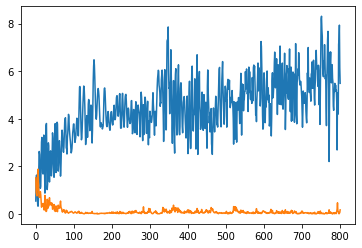

In [585]:
plot(G_losses)
plot(D_losses)

In [462]:
# Original compilation
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=Adam(0.0002), metrics=['accuracy'])

AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=Adam(0.0002), metrics=['accuracy'])

In [479]:
# Original training

d_losses = []
a_losses = []
def train(epochs=1, batch_size=64):
    steps = epochs * len(normed_images) // batch_size
    for step_idx in tqdm_notebook(range(steps)):
        # Select 'batch_size' real images
        images_train = normed_images[np.random.randint(0, normed_images.shape[0], size=batch_size), :, :, :]
        # Generate U(-1,1) noise to generate additional 'batch_size' fake images
        noise = np.random.normal(size=[batch_size, noise_dim])
        images_fake = G.predict(noise)
        # Train discriminator on real and fake, classify as such 
        x = np.concatenate((images_train, images_fake))
        y = np.ones([2*batch_size, 1])
        y[batch_size:, :] = 0
        d_loss = DM.train_on_batch(x, y)

        y = np.ones([batch_size, 1])
        noise = np.random.normal(size=[batch_size, noise_dim])
        a_loss = AM.train_on_batch(noise, y)
        
        d_losses.append(d_loss)
        a_losses.append(a_loss)

In [464]:
train(epochs=1)

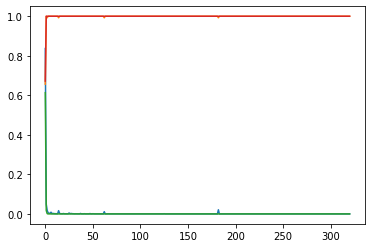

In [465]:
plot(d_losses)
plot(a_losses)

In [499]:
D.save('dogs_D.h5')
G.save('dogs_G.h5')

In [591]:
# Test discriminator on real images
D.predict(normed_images[np.random.randint(len(normed_images),size=(64))]).mean()

0.061177965

In [592]:
# Test discriminator on fake images
D.predict(G.predict(np.random.normal(size=(64,128)))).mean()

0.007829531

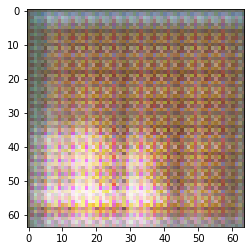

In [597]:
# Generate a fake image
imshow((G.predict(np.random.normal(size=(1,128)))*127.5+127.5).reshape(64,64,3)/255)